In [45]:
import numpy as np
import matplotlib.pyplot as plt
from platform import python_version
python_version()

'3.8.3'

The first thing I'm going to do is define a function for our Euler's Method. This will contain the code for one step of the method, using the parameters to get the velocity and position from our previous step. The function will call itself recursivley and ultimately output a dictionary for position and velocity over time. This function only works in one dimension, so it will need to be called twice, once for the x axis, and once for the y axis.

It's important to use dictionaries instead of lists, because we need to store the time step along with the value at a given time. Using a list is tempting, but because lists start at index zero, our timestep would always be one step behind our actual value. So we are using a dictionary to store the real time step as the key, and the position/velocity as the value. 

In [22]:
def euler_position(a, d0, v0, step, stop, step_count=0, d_dict={}, v_dict={}, first_call = 1):
    """
    finds position of object with respect to time using Euler's Method
    :param first_call: indicates if first call, should clear up bug with multiple function calls not clearing
    :param v_dict: ongoing dicitonary of velocity at each time step
    :param d_dict: ongoing dictionary of position at each time step
    :param a: object acceleration formula on desired axis
    :param d0: object initial position on desired axis (meters)
    :param v0: object initial velocity on desired axis (meters per second)
    :param step: desired step size for computation (seconds)
    :param stop: desired end time to stop recording data, (seconds)
    :param step_count: current step count, used for recursion
    :return: a tuple containing two python dictionaries, first being position at each step on desired axis, second being velocity at each time step on desired axis
    """
    if first_call == 1:
        d_dict = {}
        v_dict = {}
    if step * step_count < stop:
        acc = eval(a)  # Converts the string input 'a' to a float acc
        v = acc * step + v0  # Finds velocity at current time step using previous time step's velocity (v0)
        d = v * step + d0  # Finds the position at current time step using previous time step's position (d0) and current time step's velocity (v)
        d2_dict = d_dict
        d2_dict.update({(step_count+1) * step:d})  # Adds current position to dictionary of positions for each time step
        v2_dict = v_dict
        v2_dict.update({(step_count+1) * step:v})  # Adds current velocity to dictionary of velocities for each time step
        euler_position(a, d, v, step, stop, step_count + 1, d2_dict, v2_dict, 0)  # Calls function again for next time step
        return d2_dict, v2_dict

Now that we have our function, let's enter the Initial conditions provided in the document.
Something to note is that our initial velocity is given in polar form, so we will need to break it down to Cartesian form using trig.


In [23]:
v_i = 30  # magnitude of the initial velocity of the ball
angle_i = 40  # direction of the initial velocity of the ball in degrees
ax = "-(10 + 0.5 * v0)"  # Equation for acceleration of the ball in the x direction
ay = "-(9.81 + 0.5 * v0)"  # Equation for acceleration of the ball in the y direction

Now that we have our initial conditions entered, we need to convert the polar coordinates into Cartesian using trig.

In [24]:
v_i_x = v_i * np.cos(angle_i*np.pi/180)  # Finds magnitude in x direction by multiplying v_i by cos(40)
v_i_y = v_i * np.sin(angle_i*np.pi/180)  # Finds magnitude in y direction by multiplying v_i by sin(40)
print(v_i_x)
print(v_i_y)

22.98133329356934
19.283628290596177


Now that we have the initial conditions defined, we need to decide on a step size. 
We want a step size small enough to make the loss of a numerical solution neglegible, yet large enough that we aren't waiting around for the program to finish. I'm going to try a step size of 0.0001 to start. This might be a little small, so we will have to see how long it takes to run. 

In [25]:
step_size = 0.0001

Now that we have the step size, lets run our function to a time of 30 seconds for the x axis. This should be more then enough time for the ball to come to a rest in the horizontal axis. We can then fine tune how long we would like the program to run for for the y axis and out other tests.

In [26]:
end_time = 30
#ball_x = euler_position(ax, 0, v_i_x, step_size, end_time)

I tried running the above function, and the kernel immediatly died, so I'm going to assume the step size is too small
Let's try running the function with a step size of 0.01 instead.

In [27]:
step_size = 0.01
#ball_x = euler_position(ax, 0, v_i_x, step_size, end_time)

Same issue again, let's try a step of 0.1 and a time of 10 seconds.

In [32]:
step_size = 0.1
end_time = 10
ball_x = euler_position(ax, 0, v_i_x, step_size, end_time)

So this time our function executed properly, we now have a tuple - "ball_x" which contains the position and velocity for each time step.
Let's graph the position using matplotlib for a quick sanity check.

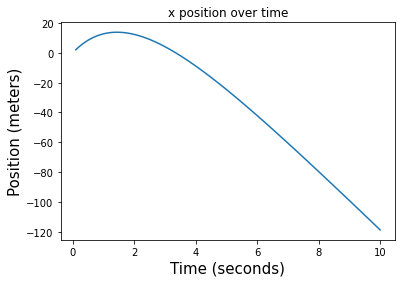

In [33]:
plt.figure()  # Creating figure object
plt.plot(ball_x[0].keys(), ball_x[0].values(), label = "x - position")  # plotting position dict, which is the 0th index in the ball_x tuple
plt.title("x position over time")
plt.xlabel("Time (seconds)", fontsize = 15)  # Creating the x label
plt.ylabel("Position (meters)", fontsize = 15)  # Creating the y label
plt.show()

Now that we have our preliminary graph for the x direction, lets do the same for the y direction.

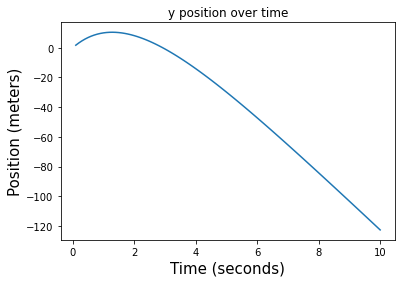

In [34]:
ball_y = euler_position(ay, 0, v_i_y, step_size, end_time)
plt.plot(ball_y[0].keys(), ball_y[0].values(), label = "y - position")  # plotting position dict, which is the 0th index in the ball_y tuple
plt.title("y position over time")
plt.xlabel("Time (seconds)", fontsize = 15)  # Creating the x label
plt.ylabel("Position (meters)", fontsize = 15)  # Creating the y label
plt.show()

First thing we notice about these graphs is they're strikingly similar. This makes sense, as the acceleration equations for each direction are nearly identical.

Now, Let's try and find the time of flight of the ball, we can do this by simply finding the point at which our plot reaches zero in the y direction, as this is where the ball hits the ground. There's a number of ways we can do this, I'm going to use a loop to iterate through the dictionary to find where the position value first becomes negative, then return the time value before that. This should give a very close aproximation of when the ball hits the ground.

In [35]:
def find_tof(ball_tuple, step):
    '''
    finds the time of flight of the ball
    :param ball_tuple: tuple containing position and velocity data for ball in y direction
    :param step: step size of input ball
    :return: time step just just before the ball hits an elevation of zero (the ground)
    '''
    for item in ball_tuple[0].items():  # iterates through dictionary represented as list of tuples
        if item[1] < 0:  # True if the y position is below zero (below the ground)
            return np.round(item[0]-step, decimals = 2)  # Returns last time step before position became underground

Now that we have the time of flight function, we can call it to find the time of flight of our ball.

In [36]:
ball_tof = find_tof(ball_y, step_size)  # Assigning the time of flight to a variable to be used later
print(ball_tof)

2.9


So the time of flight of our ball is about  2.9 seconds. We could get a more accurate number using more time steps, but the notebook kernel crashes with that many operations, so this number will  have to do. Out of curiousity I ran the program in PyCharm and found that running Python has a recursion depth limit, and we are hitting that limit by attempting to call the function that many times. 

Now that we have a general idea of when our ball hits the ground, we can reduce the amount of time we need our function to run, and thus the number of calls. This will hopefully free up the recursion depth needed to call the function with a time step of 0.01 and thus give us a more accurate estimation. Let's run for 4 seconds at a step size of 0.01.

In [37]:
step_size = 0.01  # Setting new step size
end_time = 4  # Setting new end time
ball_y = euler_position(ay, 0, v_i_y, step_size, end_time)  # Creating new dictionary using new parameters
ball_tof = find_tof(ball_y, step_size)  # Finding new time of flight in steps
print(ball_tof)

3.11


Our output is 3.11, so our ball hits the ground after aproximately 3.11 seconds

Now that we know when our ball is going to hit the ground, we can use that time to find where the ball will be in the x direction as it hits the ground. Let's call the Euler function again, this time for the x axis using our new time step and end time. then we can find the position of the ball after 3.11 seconds. This will be the range of the ball in the x direcion. 

In [38]:
ball_x = euler_position(ax, 0, v_i_x, step_size, end_time)
ball_range = np.round(ball_x[0].get(ball_tof), decimals = 2)  # Rounding to two decimals, as that is the sig-figs given in our equation of motion
print(ball_range)

5.34


Our output was 5.34, So our ball's position was 5.34 meters in the x direction when it hit the ground.

Looking back at our preliminary graphs, they don't say much beyond the general trajectory of the ball in each direciton over time because of the unrealistically large time measured. Let's use our new knowlege of when the trajectory ends to make a more readable graph for x(t) and y(t). 

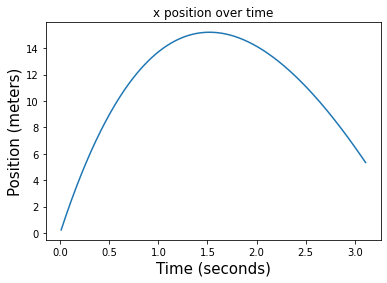

In [39]:
end_time = ball_tof  # setting end_time equal to the time of flight of the ball
ball_x = euler_position(ax, 0, v_i_x, step_size, end_time)  # Creating new x ball trajectory for new end time
plt.plot(ball_x[0].keys(), ball_x[0].values(), label = "x - position")  # plotting position dict, which is the 0th index in the ball_x tuple
plt.title("x position over time")
plt.xlabel("Time (seconds)", fontsize = 15)  # Creating the x label
plt.ylabel("Position (meters)", fontsize = 15)  # Creating the y label
plt.show()

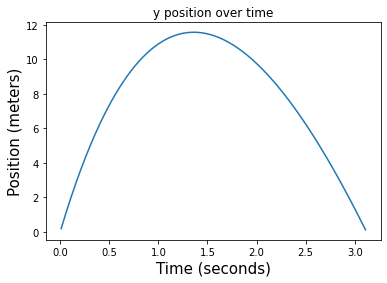

In [40]:
end_time = ball_tof  # setting end_time equal to the time of flight of the ball
ball_y = euler_position(ay, 0, v_i_y, step_size, end_time)  # Creating new y ball trajectory for new end time
plt.plot(ball_y[0].keys(), ball_y[0].values(), label = "y - position")  # plotting position dict, which is the 0th index in the ball_y tuple
plt.title("y position over time")
plt.xlabel("Time (seconds)", fontsize = 15)  # Creating the x label
plt.ylabel("Position (meters)", fontsize = 15)  # Creating the y label
plt.show()

These graphs are much more readable than the two preliminary graphs, we can see that the ball actually travels farther than its eventual stopping point in the x direction. And the y graph clearly shows the position reaching zero at the end of our graph. Which is what we were trying to achieve with our find_tof function.

Now that we have these two trajectories, let's compare the change in position between the two axis. Creating one y vs x graph that shows the total 2D position of the ball throughout it's trajectory. 

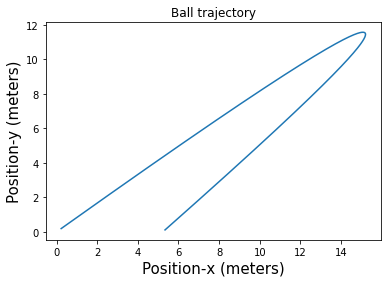

In [41]:
plt.plot(ball_x[0].values(), ball_y[0].values())  # Plotting x position vs y position
plt.title("Ball trajectory")
plt.xlabel("Position-x (meters)", fontsize = 15)  # Creating the x label
plt.ylabel("Position-y (meters)", fontsize = 15)  # Creating the y label
plt.show()

Now we have a graph of the trajectory of the ball. We can see that the ball initially travels far in both directions, but circles back and nearly returns to its initial position. This trajectory makes sense if we think about our acceleration equation and initial conditions. With our acceleration equations being nearly identical in each direrction, and our launch angle being close to 45 degrees. Our graph is expected to look not entierly dissimilar from y = x, as the two distances are not changing at incredibly different rates.

Let's try adjusting some of the initial conditions and seeing how they effect our trajectory. Let's see what happens when the launch angle is changed to 45 degrees. At this angle the initial velocity in x and y will be the same, so the only difference in the trajectory will come from the difference in the forces acting on the ball in each direction after launch, which is minimal. I expect the trajectory to be similar to y = x, but due to the slightly greater acceleration in the x direction, I expect the ball to come to a rest just behind the initial position. 

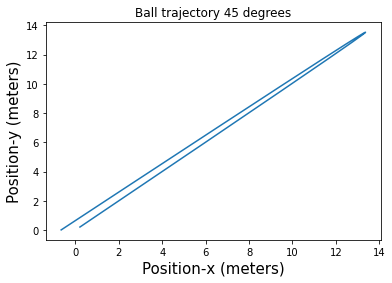

In [42]:
angle_i = 45
v_i_x = v_i * np.cos(angle_i*np.pi/180)  # Finds magnitude in x direction by multiplying v_i by cos(45)
v_i_y = v_i * np.sin(angle_i*np.pi/180)  # Finds magnitude in y direction by multiplying v_i by sin(45)
ball_y = euler_position(ay, 0, v_i_y, step_size, 5)  # First find y(t) to find the time of flight
end_time = find_tof(ball_y, step_size)  # Find end time using find_tof
ball_y = euler_position(ay, 0, v_i_y, step_size, end_time)  # Create new trajectories using the end time from time of flight data
ball_x = euler_position(ax, 0, v_i_y, step_size, end_time)
plt.plot(ball_x[0].values(), ball_y[0].values())  # Plotting x position vs y position
plt.title("Ball trajectory 45 degrees")
plt.xlabel("Position-x (meters)", fontsize = 15)  # Creating the x label
plt.ylabel("Position-y (meters)", fontsize = 15)  # Creating the y label
plt.show()

The graph matches our predictions perfectly. The after the ball was kicked, the wind and gravity accelerated it in a nearly identical manner, causing it to just about return to its initial position. The acceleration from the wind was slightly greater in magnitude however, so the ball ended up landing just behind its starting point.

Now let's try changing the force acting on the ball. What happens if the wind were removed from the equation? The motion would become a more traditional projectile arc, but still affected by air resistance.The ball will no longer forced backwards nearly as fast as it is forced up, so it will travel a much greater distance in the x direction. Here I'm going to change the x acceleration, removing the "10" term. This term is the acceleration resulting from the wind, so removing it will remove the wind from the equation. The y acceleration will be kept the same.

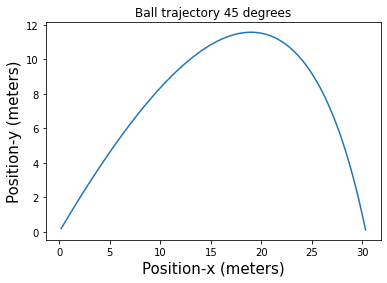

In [43]:
ax = ax = "-(0.5 * v0)"
angle_i = 40
v_i_x = v_i * np.cos(angle_i*np.pi/180)  # Finds magnitude in x direction by multiplying v_i by cos(40)
v_i_y = v_i * np.sin(angle_i*np.pi/180)  # Finds magnitude in y direction by multiplying v_i by sin(40)
ball_y = euler_position(ay, 0, v_i_y, step_size, 5)  # First find y(t) to find the time of flight
end_time = find_tof(ball_y, step_size)  # Find end time using find_tof
ball_y = euler_position(ay, 0, v_i_y, step_size, end_time)  # Create new trajectories using the end time from time of flight data
ball_x = euler_position(ax, 0, v_i_y, step_size, end_time)
plt.plot(ball_x[0].values(), ball_y[0].values())  # Plotting x position vs y position
plt.title("Ball trajectory 45 degrees")
plt.xlabel("Position-x (meters)", fontsize = 15)  # Creating the x label
plt.ylabel("Position-y (meters)", fontsize = 15)  # Creating the y label
plt.show()

As expected the ball travels much farther here, following a more traditional arc. It's also interesting to note that the vertical height maximum doesn't change. This makes sense, as with the acceleration in y unchanged, neither should its position in y at any given point. 

Now let's see what happens if the initial velocity is changed. Let's try a modest 120m/s launch speed for our ball. This will cause the ball to start out with a velocity four times the origional, however I do not expect the ball to take four times as long to land. This is because with the greater velocity, also comes a greater magnitude of acceleration acting against it, since our force of air resistance is directly related to the velocity of the ball.

9.73


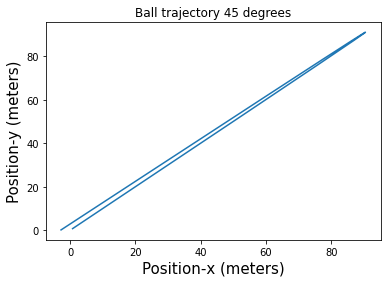

In [44]:
v_i = 120  # magnitude of the initial velocity of the ball
ax = "-(10 + 0.5 * v0)"  # Equation for acceleration of the ball in the x direction
ay = "-(9.81 + 0.5 * v0)"  # Equation for acceleration of the ball in the y direction
angle_i = 40
v_i_x = v_i * np.cos(angle_i*np.pi/180)  # Finds magnitude in x direction by multiplying v_i by cos(40)
v_i_y = v_i * np.sin(angle_i*np.pi/180)  # Finds magnitude in y direction by multiplying v_i by sin(40)
ball_y = euler_position(ay, 0, v_i_y, step_size, 10)  # First find y(t) to find the time of flight
end_time = find_tof(ball_y, step_size)  # Find end time using find_tof
print(end_time)  # Printing time of flight for use in 
ball_y = euler_position(ay, 0, v_i_y, step_size, end_time)  # Create new trajectories using the end time from time fo flight data
ball_x = euler_position(ax, 0, v_i_y, step_size, end_time)
plt.plot(ball_x[0].values(), ball_y[0].values())  # Plotting x position vs y position
plt.title("Ball trajectory 45 degrees")
plt.xlabel("Position-x (meters)", fontsize = 15)  # Creating the x label
plt.ylabel("Position-y (meters)", fontsize = 15)  # Creating the y label
plt.show()

I had the program print out the time of flight of the ball so we can compare it to the origional time of flight. The origional ball took 3.11 seconds to land, our increased initial velocity ball took 9.73 seconds to land. If the time were quadrupled just like the initial velocity, the ball would be expected to take 12.44 seconds to hit the ground, but it took significantly less time to do so. This is because of the air resistance slowing the ball down much faster at these higher velocities. 